In [2]:
import pandas as pd
from sasviya.ml.tree import ForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# 데이터 가져오기
url =  "https://github.com/bong-ju-kang/data/raw/refs/heads/master/hmeq.csv"
df = pd.read_csv(url)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [45]:


# 📌 1. 데이터 준비 (HMEQ 데이터 불러오기 예시)
# 이미 DataFrame으로 되어 있다고 가정 (예: df = pd.read_csv('hmeq.csv'))
# 결측값 처리
df = df.dropna()

# 타겟 및 입력 변수 설정
target = 'BAD'
input_vars = [col for col in df.columns if col != target]

# 훈련/테스트 분할
X = df[input_vars]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 📌 2. 모델 생성 및 학습
model = ForestClassifier(
    n_estimators=300,
    bootstrap=0.7,
    criterion='igr',
    max_depth=10,
    min_samples_leaf=5,
    oob_score=True,
    verbose=1
)

# 명목형 변수 자동 지정 (object, category형만)
nominal_vars = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 모델 학습
model.fit(X_train, y_train, nominals=nominal_vars)

# 📌 3. 예측 및 평가
y_pred = model.predict(X_test)

# 성능 평가
print("📊 Classification Report")
print(classification_report(y_test, y_pred))

# 📌 4. 변수 중요도 보기
print("📈 Feature Importances")
print(model.feature_importances_)

# 📌 5. OOB 점수 (부트스트랩 외 데이터 기반 정확도)
print("✅ OOB Score:", model.oob_score_)

             Model Information              

                           Descr       Value
                 Number of Trees  300.000000
Number of Selected Variables (M)    4.000000
              Random Number Seed    0.000000
        Bootstrap Percentage (%)   70.000000
                  Number of Bins   50.000000
             Number of Variables   12.000000
    Confidence Level for Pruning    0.250000
        Max Number of Tree Nodes  101.000000
        Min Number of Tree Nodes   53.000000
          Max Number of Branches    2.000000
          Min Number of Branches    2.000000
            Max Number of Levels   11.000000
            Min Number of Levels   11.000000
            Max Number of Leaves   51.000000
            Min Number of Leaves   27.000000
          Maximum Size of Leaves 1380.000000
          Minimum Size of Leaves    5.000000
              Out-of-Bag MCR (%)    6.669499
        Average number of Leaves   35.786667

📊 Classification Report
              precision    re

In [46]:
# 예측 확률 가져오기
y_proba = model.predict_proba(X_test)

# # 예측 확률은 shape=(n_samples, 2)이고,
# # 두 번째 열이 양성 클래스(1)의 확률
df_score = X_test.copy()
type(y_proba)
df_score['P_BAD1'] = y_proba.iloc[:, 1]  # 📌 확률
df_score['P_BAD0'] = y_proba.iloc[:, 0]  # 📌 확률
df_score['BAD'] = y_test.values     # 📌 실제값
df_score['BAD'] = df_score['BAD'].astype(str)



In [47]:
# 평가 클래스 객체 생성
from sasviya.ml.assess import Assess

assess = Assess(
    input='P_BAD1',       # 📌 예측 확률 컬럼 이름
    y_true='BAD',         # 📌 실제 타겟 변수
    pos_label='1',        # 📌 관심 클래스 (예: 부실 대출)
    cut_step=0.01,        # 📌 ROC/PR 등 곡선 그리기용 간격
    user_cutoff=0.5,      # 📌 혼동행렬, F1 등 평가할 기준 확률값
    p_var=['P_BAD0'],
    p_pos_label=['0'],
   verbose=2             # 📌 출력 상세 레벨
)


In [32]:
# dir(assess)

In [31]:
df_score.columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ',
       'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'P_BAD1', 'P_BAD0', 'BAD'],
      dtype='object')

In [48]:
# summarize()로 성능 평가 수행
assess.summarize(df_score)

# 평가 결과 출력
print("AUC:", assess.auc_)
print("Accuracy:", assess.accuracy_score_)
print("F1:", assess.f1_score_)
print("Confusion Matrix:\n", assess.confusion_matrix_)



AUC: 0.8866720874337849
Accuracy: 0.9405940594059405
F1: 0.53125
Confusion Matrix:
 [[ 34  57]
 [  3 916]]


In [42]:
# ROC 데이터
type(assess.roc_curve_)
assess.roc_curve_[0]

0     1.000000
1     0.879121
2     0.857143
3     0.835165
4     0.824176
        ...   
95    0.043956
96    0.021978
97    0.010989
98    0.000000
99    0.000000
Name: Sensitivity, Length: 100, dtype: float64

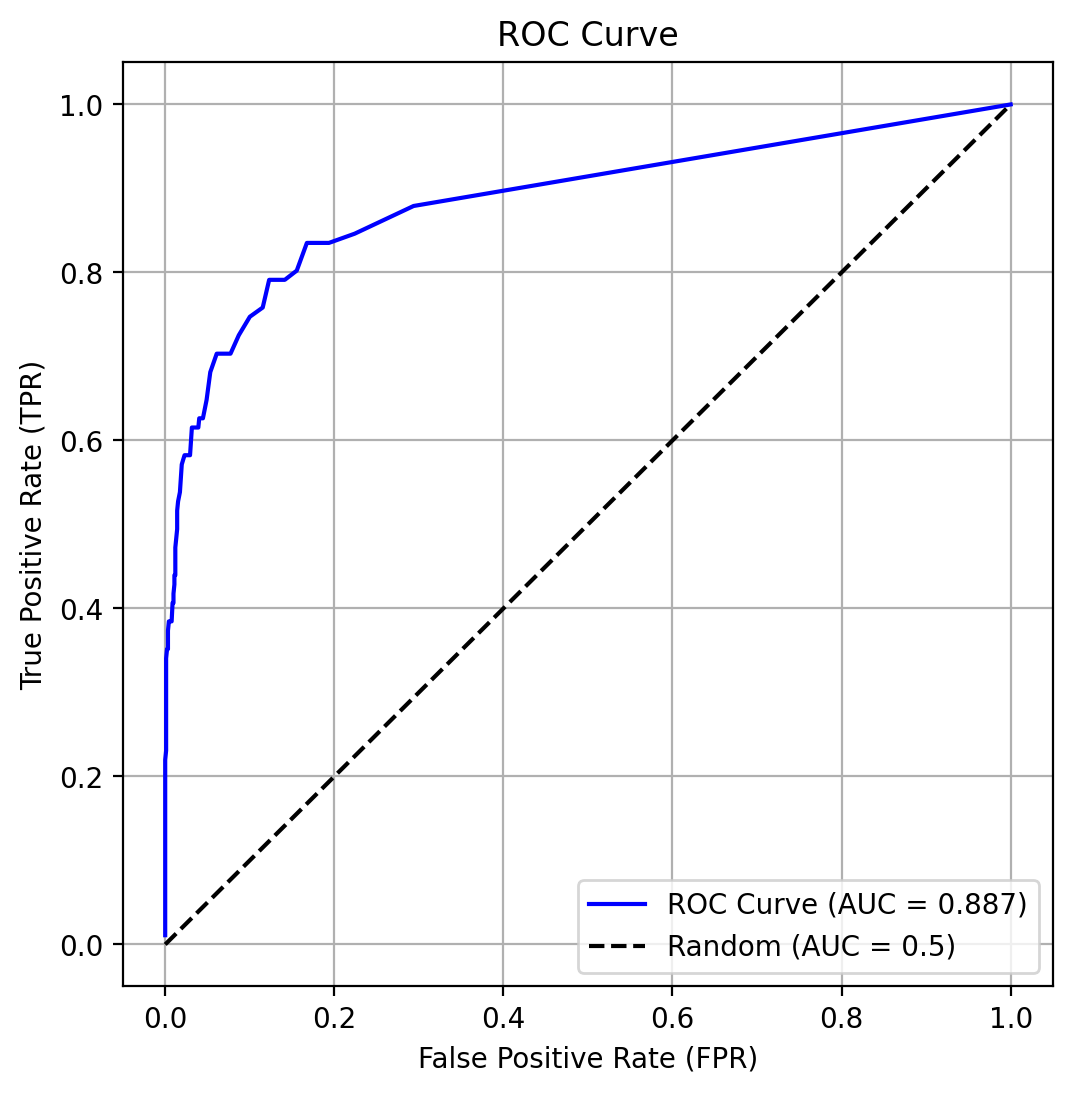

In [49]:
import matplotlib.pyplot as plt

# ROC 데이터 가져오기
roc = assess.roc_curve_
fpr = roc[1]
tpr = roc[0]

# AUC
auc = assess.auc_

# 플롯
plt.figure(figsize=(6, 6), dpi=200)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [50]:
# 결정 함수 값 얻기
decision_scores = model.decision_function(X_test)

# 이진 분류일 경우 shape = (n_samples, )
print(decision_scores[:5])

2151    0.020000
4264    0.000000
1649    0.410000
5137    0.000000
563     0.006667
Name: P_BAD1, dtype: float64


In [ ]:
# 모델 저장
# export to .astore file
model.export(file='/workspaces/bnn/model/forest_model.astore', replace=True)



In [ ]:
# 파일 없이 메모리로 export
astore_binary = model.export()
# astore_binary는 바이너리 객체로, 서버로 바로 전송 가능


In [55]:
from sasviya import load_model
model.save('/workspaces/bnn/model/forest_model.pkl')
loaded_model = load_model('/workspaces/bnn/model/forest_model.pkl')


In [56]:
loaded_model.decision_function(X_test)

2151    0.020000
4264    0.000000
1649    0.410000
5137    0.000000
563     0.006667
          ...   
1542    0.013333
5267    0.013333
4720    0.526667
3723    0.943333
1289    0.003333
Name: P_BAD1, Length: 1010, dtype: float64

In [57]:
model.describe()

[Key]

               Store Key                
 
                                      Key
 D0278D69E7F531FF2BEFE5E4EBAB63237E76E0A7

[Description]

        Basic Information         
 
       Attribute              Value
 Analytic Engine  tree-based models
    Time Created 24Apr2025:07:43:50

[InputVariables]

                    Input Variables                    
 
    Name  Length  Role           Type RawType FormatName
    LOAN     8.0 Input       Interval     Num           
 MORTDUE     8.0 Input       Interval     Num           
   VALUE     8.0 Input       Interval     Num           
  REASON     7.0 Input Classification Varchar           
     JOB     7.0 Input Classification Varchar           
     YOJ     8.0 Input       Interval     Num           
   DEROG     8.0 Input       Interval     Num           
  DELINQ     8.0 Input       Interval     Num           
   CLAGE     8.0 Input       Interval     Num           
    NINQ     8.0 Input       Interval     Num           
    CLNO     8.0 Input       Interval     Num           
 DEBTINC     8.0 Input       Interval     Num           

[OutputVariables]

            Output Variables             
 
   Name  Length      Type            Label
 P_BAD1     8.0       Num Predicted: BAD=1
 P_BAD0     8.0       Num Predicted: BAD=0
  I_BAD    12.0 Character        Into: BAD
 _WARN_     4.0 Character         Warnings